In [1]:
import importlib
import numpy as np
from openai import OpenAI
import os
import pandas as pd
from dotenv import load_dotenv, find_dotenv
import json
from collections import defaultdict
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns 

sns.set_theme()

### Step 1: Prep Data

In [2]:
sp = pd.read_pickle('data/sp500_constituents.pkl')
fomc = pd.read_pickle('data/fomc_statements.pkl')
fomc = fomc.drop(columns='statement')
fomc = fomc.rename(columns={'cleaned_statement':'statement'})
fomc = fomc[fomc['date']>='2000-01-03'].reset_index(drop=True)
fomc = fomc[fomc['date'] <= '2024-01-01'].reset_index(drop=True)

### Step 2: Create Fine Tuned Model
<!-- - OpenAI documentation recommended to get prompts as good as possible on a model that is not fine tuned, and then once this is done, fine tune the model   -->
[Chat Completions Documentation](https://platform.openai.com/docs/guides/chat-completions/overview)   

Roles:
- System (optional): Sets the behavior of the assistant  
- User: provide requests or comments for the assistant to respond to  

In [10]:
# load nate key
_ = load_dotenv(find_dotenv())
api_key = os.environ.get('OPENAI_API_KEY') 
client = OpenAI(api_key=api_key)

response = client.files.create(
  file=open("data/train_data.jsonl", "rb"),
  purpose="fine-tune"
)

In [16]:
# file id
response.id

'file-dVRcwwwpHAzoQUKujEGazzAn'

In [17]:
# specified model to use in writeup
model = "gpt-3.5-turbo-0125"

fine_tune_response = client.fine_tuning.jobs.create(
  training_file=response.id,
  model=model
)

In [23]:
client.fine_tuning.jobs.list(limit=10)
fine_tune_response
# client.fine_tuning.jobs.retrieve(response.id)

FineTuningJob(id='ftjob-Zdt8hsTrR0HZaEZEJ1ZEN603', created_at=1727583972, error=Error(code=None, message=None, param=None), fine_tuned_model=None, finished_at=None, hyperparameters=Hyperparameters(n_epochs='auto', batch_size='auto', learning_rate_multiplier='auto'), model='gpt-3.5-turbo-0125', object='fine_tuning.job', organization_id='org-mlcW3CadBiACwaM4gyhnYXxH', result_files=[], seed=537148697, status='validating_files', trained_tokens=None, training_file='file-dVRcwwwpHAzoQUKujEGazzAn', validation_file=None, estimated_finish=None, integrations=[], user_provided_suffix=None)

In [26]:
client.fine_tuning.jobs.retrieve("ftjob-Zdt8hsTrR0HZaEZEJ1ZEN603")

FineTuningJob(id='ftjob-Zdt8hsTrR0HZaEZEJ1ZEN603', created_at=1727583972, error=Error(code=None, message=None, param=None), fine_tuned_model='ft:gpt-3.5-turbo-0125:personal::ACg0wQ38', finished_at=1727584800, hyperparameters=Hyperparameters(n_epochs=3, batch_size=1, learning_rate_multiplier=2), model='gpt-3.5-turbo-0125', object='fine_tuning.job', organization_id='org-mlcW3CadBiACwaM4gyhnYXxH', result_files=['file-LkVL0M8MCUASnhq1QdqdXrT5'], seed=537148697, status='succeeded', trained_tokens=279411, training_file='file-dVRcwwwpHAzoQUKujEGazzAn', validation_file=None, estimated_finish=None, integrations=[], user_provided_suffix=None)

### Step 2: Fine Tune Model
<!-- - OpenAI documentation recommended to get prompts as good as possible on a model that is not fine tuned, and then once this is done, fine tune the model   -->
[Chat Completions Documentation](https://platform.openai.com/docs/guides/chat-completions/overview)   

Roles:
- System (optional): Sets the behavior of the assistant  
- User: provide requests or comments for the assistant to respond to  

In [5]:
# max_tokens: how many words gpt can output
# temperature: randomness. 0 has no randomness, 2 is totally random 

### Step 3: Craft Prompts for Industry Groups

Strategy 2: Aims to have GPT forecast the best and worst performing industry group over the next day

In [47]:
# use gpt to decide what industry to long/short
def construct_portfolio_by_industry_group(statement, date):
    messages = [
        {
            # system message to describe the chatbot
            "role": "system",
            "content": f"""As of {date.strftime('%Y-%m-%d')}, you are a financial analyst specializing in 
            interpreting FOMC statements to predict GICS industry group returns in the stock market."""
        },
        {   
            # system to describe what we are asking the
            "role": "user",
            "content": f"""Based on the FOMC statement released on {date.strftime('%Y-%m-%d')}, please identify:

        - The industry group that will have the highest returns over the next day.
        - The industry group that will have the lowest returns over the next day.

        Provide your answer in the following format:

        'long: industry_group, short: industry_group'

Recall the list of industry groups to choose from are:
['Energy',
 'Materials',
 'Capital Goods',
 'Commercial & Professional Services',
 'Transportation',
 'Automobiles & Components',
 'Consumer Durables & Apparel',
 'Consumer Services',
 'Retailing',
 'Media & Entertainment',
 'Food & Staples Retailing',
 'Food, Beverage & Tobacco',
 'Household & Personal Products',
 'Health Care Equipment & Services',
 'Pharmaceuticals, Biotechnology & Life Sciences',
 'Banks',
 'Diversified Financials',
 'Insurance',
 'Real Estate',
 'Software & Services',
 'Technology Hardware & Equipment',
 'Semiconductors & Semiconductor Equipment',
 'Telecommunication Services',
 'Media & Entertainment',
 'Utilities',
 'Real Estate',
 'Real Estate Management & Development']


FOMC Statement:
\"\"\"
{statement}
\"\"\"
"""
        }
    ]
    
    # call the chat completions api using the client object
    response = client.chat.completions.create(
        # model="gpt-3.5-turbo-0125",  # model as specified in the writeup
        model = 'ft:gpt-3.5-turbo-0125:personal::ACg0wQ38', # fine tuned model (sucks rn)
        messages=messages,
        temperature=0,  # set temperature to 0 for deterministic output
        max_tokens=256  # limit the number of tokens to only capture the sentiment label
    )
    
    analysis = response.choices[0].message.content.strip()
    return analysis


### Step 4: Parse GPT Response
Creates columns for the industry group to long and short according to the forecasts by GPT

In [80]:
# # parse json to list
# def parse_sector_analysis(analysis):
#     try:
#         data = json.loads(analysis)
#         long_gics = data.get('long', [])
#         short_gics = data.get('short', [])
#         return long_gics, short_gics
#     except json.JSONDecodeError:
#         print("Failed to parse GPT response as JSON.")
#         return [], []

In [49]:
def parse_sector_analysis(analysis):
    try:
        # find position of "long:" and "short:"
        long_part = analysis.split("long: ")[1].split(", short: ")[0].strip()
        short_part = analysis.split(", short: ")[1].strip()
        return long_part, short_part
    except (IndexError, AttributeError):
        print("Failed to parse GPT response as expected.")
        return "", ""


In [50]:
tqdm.pandas()  

# add cols of which group to long/short
def get_sectors(row):
    analysis = construct_portfolio_by_industry_group(row['statement'], row['date'])
    long_gics, short_gics = parse_sector_analysis(analysis)
    return pd.Series({'long': long_gics, 'short': short_gics})

# apply the function to each row
fomc[['long', 'short']] = fomc.progress_apply(get_sectors, axis=1)


100%|██████████| 159/159 [02:54<00:00,  1.09s/it]


In [54]:
# has a columns for what sector/industry group/ industry
fomc

,date,statement,long,short
0,2000-02-02,immediate release federal open market committe...,Semiconductors & Semiconductor Equipment,Energy
1,2000-03-21,immediate release federal open market committe...,Semiconductors & Semiconductor Equipment,Energy
2,2000-05-16,immediate release federal open market committe...,Semiconductors & Semiconductor Equipment,Energy
3,2000-06-28,immediate release federal open market committe...,Semiconductors & Semiconductor Equipment,Energy
4,2000-08-22,immediate release federal open market committe...,Semiconductors & Semiconductor Equipment,Energy
...,...,...,...,...
154,2023-06-14,recent indicators suggest economic activity co...,Real Estate Management & Development,Banks
155,2023-07-26,recent indicators suggest economic activity ex...,Real Estate Management & Development,Banks
156,2023-09-20,recent indicators suggest economic activity ex...,Real Estate Management & Development,Banks
157,2023-11-01,recent indicators suggest economic activity ex...,Real Estate Management & Development,Banks


In [56]:
sp

,date,permno,comnam,ticker,gvkey,ret,gsector,ggroup,gind,sector,industry,group
0,2000-01-03,64936,DOMINION RESOURCES INC VA,D,004029,-0.028662,55,5510,551030,Utilities,Multi-Utilities,Utilities
1,2000-01-03,24205,F P L GROUP INC,FPL,004517,-0.036496,55,5510,551010,Utilities,Electric Utilities,Utilities
2,2000-01-03,60441,MIRAGE RESORTS INC,MIR,005211,-0.028926,25,2530,253010,Consumer Discretionary,"Hotels, Restaurants & Leisure",Consumer Services
3,2000-01-03,45751,MARSH & MCLENNAN COS INC,MMC,007065,-0.011757,40,4030,403010,Financials,Insurance,Insurance
4,2000-01-03,76887,ALLIED WASTE INDUSTRIES INC,AW,022140,-0.042553,20,2020,202010,Industrials,Commercial Services & Supplies,Commercial & Professional Services
...,...,...,...,...,...,...,...,...,...,...,...,...
3021419,2023-12-29,87445,TELEDYNE TECHNOLOGIES,TDY,126721,0.004683,45,4520,452030,Information Technology,Communications Equipment,Technology Hardware & Equipment
3021420,2023-12-29,21792,CENTERPOINT ENERGY INC,CNP,005742,0.000350,55,5510,551030,Utilities,Multi-Utilities,Utilities
3021421,2023-12-29,13356,PHILLIPS 66,PSX,170841,0.002258,10,1010,101020,Energy,Energy Equipment & Services,Energy
3021422,2023-12-29,58819,ALLIANT ENERGY CORP,LNT,011554,-0.000390,55,5510,551010,Utilities,Electric Utilities,Utilities


### Step 5: Construct Portfolio

In [82]:
display(sp.columns)

print(f"Number of records without gics information: {sp['group'].isnull().sum()}")

Index(['date', 'permno', 'comnam', 'ticker', 'gvkey', 'ret', 'gsector',
       'ggroup', 'gind', 'sector', 'industry', 'group'],
      dtype='object')

Number of records without gics information: 0


In [58]:
fomc

,date,statement,long,short
0,2000-02-02,immediate release federal open market committe...,Semiconductors & Semiconductor Equipment,Energy
1,2000-03-21,immediate release federal open market committe...,Semiconductors & Semiconductor Equipment,Energy
2,2000-05-16,immediate release federal open market committe...,Semiconductors & Semiconductor Equipment,Energy
3,2000-06-28,immediate release federal open market committe...,Semiconductors & Semiconductor Equipment,Energy
4,2000-08-22,immediate release federal open market committe...,Semiconductors & Semiconductor Equipment,Energy
...,...,...,...,...
154,2023-06-14,recent indicators suggest economic activity co...,Real Estate Management & Development,Banks
155,2023-07-26,recent indicators suggest economic activity ex...,Real Estate Management & Development,Banks
156,2023-09-20,recent indicators suggest economic activity ex...,Real Estate Management & Development,Banks
157,2023-11-01,recent indicators suggest economic activity ex...,Real Estate Management & Development,Banks


In [83]:
portfolio_records = []

for idx, row in fomc.iterrows():
    date = row['date']
    long_gics = row['long']
    short_gics = row['short']
    
    if not long_gics and not short_gics:
        print(f'no stocks identified for {date}')
        continue
    
    # S&P constituents on date
    stocks_on_date = sp[sp['date'] == date]
    
    # stocks to long
    long_stocks = stocks_on_date[stocks_on_date['group'].isin([long_gics])]
    
    # stocks to short
    short_stocks = stocks_on_date[stocks_on_date['group'].isin([short_gics])]
    
    # record positions
    for permno in long_stocks['permno'].unique():
        portfolio_records.append({
            'date': date,
            'permno': permno,
            'position': 'long'
        })
    
    for permno in short_stocks['permno'].unique():
        portfolio_records.append({
            'date': date,
            'permno': permno,
            'position': 'short'
        })


In [84]:
fomc

,date,statement,long,short
0,2000-02-02,immediate release federal open market committe...,Semiconductors & Semiconductor Equipment,Energy
1,2000-03-21,immediate release federal open market committe...,Semiconductors & Semiconductor Equipment,Energy
2,2000-05-16,immediate release federal open market committe...,Semiconductors & Semiconductor Equipment,Energy
3,2000-06-28,immediate release federal open market committe...,Semiconductors & Semiconductor Equipment,Energy
4,2000-08-22,immediate release federal open market committe...,Semiconductors & Semiconductor Equipment,Energy
...,...,...,...,...
154,2023-06-14,recent indicators suggest economic activity co...,Real Estate Management & Development,Banks
155,2023-07-26,recent indicators suggest economic activity ex...,Real Estate Management & Development,Banks
156,2023-09-20,recent indicators suggest economic activity ex...,Real Estate Management & Development,Banks
157,2023-11-01,recent indicators suggest economic activity ex...,Real Estate Management & Development,Banks


In [85]:
# Each FOMC statement has the stocks to long and the stocks to short
df_portfolio = pd.DataFrame(portfolio_records)
df_portfolio

,date,permno,position
0,2000-02-02,46886,long
1,2000-02-02,61241,long
2,2000-02-02,14702,long
3,2000-02-02,59328,long
4,2000-02-02,76201,long
...,...,...,...
5719,2023-12-13,53613,long
5720,2023-12-13,88182,long
5721,2023-12-13,12084,long
5722,2023-12-13,90199,short


In [86]:
# Check columns in df_returns
# Merge on 'Date' and 'PERMNO'
df_positions = pd.merge(df_portfolio, sp[['date', 'permno', 'ret']], 
                        left_on=['date', 'permno'], right_on=['date', 'permno'], 
                        how='left')

# Rename 'ret' to 'Return'
df_positions.rename(columns={'ret': 'return'}, inplace=True)



In [87]:
df_positions

,date,permno,position,return
0,2000-02-02,46886,long,0.064949
1,2000-02-02,61241,long,-0.013675
2,2000-02-02,14702,long,0.023577
3,2000-02-02,59328,long,-0.013555
4,2000-02-02,76201,long,0.058670
...,...,...,...,...
5719,2023-12-13,53613,long,0.020855
5720,2023-12-13,88182,long,0.034060
5721,2023-12-13,12084,long,0.010040
5722,2023-12-13,90199,short,0.046173


In [88]:
# get next day returns

# Calculate the next trading day
df_positions['close_date'] = df_positions['date'] + pd.Timedelta(days=1)

# Merge with returns on 'Close_Date' and 'PERMNO'
df_positions = pd.merge(df_positions, sp[['date', 'permno', 'ret']], 
                        left_on=['close_date', 'permno'], right_on=['date', 'permno'], 
                        how='left', suffixes=('', '_next'))

# # Rename 'ret_Next' to 'Next_Return'
df_positions.rename(columns={'ret': 'next_return'}, inplace=True)

# Drop redundant date col
df_positions.drop(columns=['date_next'], inplace=True)




In [89]:
display(df_positions.isna().sum())

date           0
permno         0
position       0
return         0
close_date     0
next_return    0
dtype: int64

In [90]:
# drop positions with missing next day returns
df_positions.dropna(subset=['next_return'], inplace=True)

In [91]:
df_positions

,date,permno,position,return,close_date,next_return
0,2000-02-02,46886,long,0.064949,2000-02-03,0.025169
1,2000-02-02,61241,long,-0.013675,2000-02-03,0.081456
2,2000-02-02,14702,long,0.023577,2000-02-03,0.032595
3,2000-02-02,59328,long,-0.013555,2000-02-03,0.041524
4,2000-02-02,76201,long,0.058670,2000-02-03,0.128079
...,...,...,...,...,...,...
5719,2023-12-13,53613,long,0.020855,2023-12-14,0.030079
5720,2023-12-13,88182,long,0.034060,2023-12-14,0.063533
5721,2023-12-13,12084,long,0.010040,2023-12-14,0.051281
5722,2023-12-13,90199,short,0.046173,2023-12-14,0.057724


In [92]:
# get realized return (i.e. negate the shorts)
def calculate_position_return(row):
    if row['position'] == 'long':
        return row['next_return']
    elif row['position'] == 'short':
        return -row['next_return']
    else:
        return 0

df_positions['position_return'] = df_positions.apply(calculate_position_return, axis=1)


In [93]:
# group by 'date' and calculate mean return to calculate returns per FOMC
df_portfolio_returns = df_positions.groupby('date')['position_return'].mean().reset_index()

df_portfolio_returns

,date,position_return
0,2000-02-02,0.020000
1,2000-03-21,0.014389
2,2000-05-16,-0.008806
3,2000-06-28,-0.023090
4,2000-08-22,-0.005635
...,...,...
154,2023-06-14,-0.016681
155,2023-07-26,0.005909
156,2023-09-20,0.010410
157,2023-11-01,-0.049868


In [94]:
df_portfolio_returns.sort_values('date', inplace=True)
df_portfolio_returns.reset_index(drop=True, inplace=True)

In [95]:
df_portfolio_returns['cumulative_return'] = (1 + df_portfolio_returns['position_return']).cumprod()


In [96]:
df_portfolio_returns['cumulative_return'].mean()

1.2084447995459067

In [97]:
# total_return = df_portfolio_returns['cumulative_return'].iloc[-1] - 1


In [98]:
# num_days = (df_portfolio_returns['date'].iloc[-1] - df_portfolio_returns['date'].iloc[0]).days
# annualized_return = (1 + total_return) ** (252 / num_days) - 1
# print(f"Annualized Return: {annualized_return * 100:.2f}%")

In [100]:
average_daily_return = df_portfolio_returns['position_return'].mean()
print(f"Average Daily Return: {average_daily_return * 100:.4f}%")

daily_volatility = df_portfolio_returns['position_return'].std()
print(f"Daily Volatility: {daily_volatility * 100:.4f}%")


Average Daily Return: 0.2448%
Daily Volatility: 1.9815%


In [101]:
sharpe_ratio = (average_daily_return / daily_volatility) * np.sqrt(252)
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")


Sharpe Ratio: 1.96


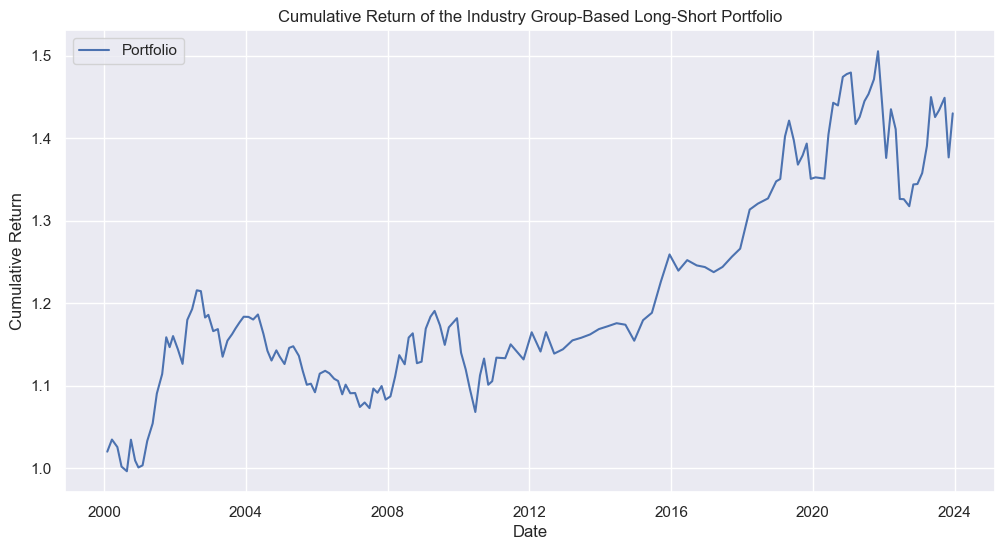

In [104]:
plt.figure(figsize=(12, 6))
plt.plot(df_portfolio_returns['date'], df_portfolio_returns['cumulative_return'], label='Portfolio')


plt.title('Cumulative Return of the Industry Group-Based Long-Short Portfolio')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.show()
